# The Voice of the Customer: Using NLP and Social Media to Extract Customer Feedback

This script was created by Kendall Ruber for the DATAcated Conference on May 19, 2021. This project uses Natural Language Processing and Machine Learning techniques to extract customer feedback from social media about a certain product. Social media data was extracted from the Sentiment140 Twitter dataset (http://help.sentiment140.com/for-students/). Only tweets that contain the word "iphone" are included in this analysis.

The goal of this script is to identify customer sentiment toward our "product", the iphone, and classify each tweet into a category based on the keywords it contains using k-means clustering. 



# Setup: Import packages and import dataset

In [1]:
# Import required packages
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import string

# NLTK packages setup
import nltk
nltk.download('punkt') # for tokenization
nltk.download('wordnet') # for stemming and lemmatization
nltk.download('averaged_perceptron_tagger') # parts of speech tagger
nltk.download('vader_lexicon')


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score


# Word cloud package installations
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kxr6264\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kxr6264\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kxr6264\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kxr6264\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Create file path for importing Sentiment140 iPhone data. 
os.getcwd() # grab current working directory
base = 'C:\\Users\\kxr6264\\Documents' # maps to my drive in my Documents.
os.chdir(base) 


In [3]:
# Read and import the social media data file
df = pd.read_excel(base + '\\sentiment140_iphoneview.xlsx')

# Preview the data to make sure it imported correctly.
df.head()

,Tweet
0,"feeling lost, naked and confused (JK, sort of)..."
1,"@benackerman BTW my iPhone is acting funny, dy..."
2,Nasty budget due and my iphone is being sent t...
3,Synching my contacts from my old mobile to iPh...
4,"New iphone, yay! Not restoring backup, no! St..."


# Text Cleansing
We want to format the text into a string and make every word lowercase in order to tokenize each word for further processing.

In [4]:
df.dtypes

Tweet    object
dtype: object

In [5]:
# convert the data type of the inquiries from float to string
df['Tweet'] = df['Tweet'].astype(str) 

# Convert all data to lowercase. This is so the analysis does not count "The" and "the" as different words
df['Tweet'] = df['Tweet'].str.lower() # makes everything in this column lowercase to avoid redundancy.

# Remove all words that begin with an @. This takes any mentioning of others/Twitter handles out of the data before we process it.
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join(word for word in x.split(' ') if not word.startswith('@')))
#df['Tweet_nouser'] = df['Tweet'].apply(lambda x: re.sub(r'@+[a-z]',' ',x))
# df['Tweet_nouser'] = df['Tweet'].apply(lambda x: re.sub(r'(\s)@\w+', r'\1', x)) 
# df['Tweet'].apply(re.sub(r'^\@.', '', x)) 
#(r'(?m)^\*.*\n?', '', s) 
#df['sentiment'] = df['cleansed'].apply(lambda x: analyzer.polarity_scores(x))
df.head()

,Tweet
0,"feeling lost, naked and confused (jk, sort of)..."
1,"btw my iphone is acting funny, dying quickly a..."
2,nasty budget due and my iphone is being sent t...
3,synching my contacts from my old mobile to iph...
4,"new iphone, yay! not restoring backup, no! st..."


In [6]:
# Tokenize the customer inquiries. This makes each word its own entity so we can process them individually in the following steps.
df['tokenized_tweets'] = [nltk.word_tokenize( str(word) ) for word in df.Tweet] 

df.head()

,Tweet,tokenized_tweets
0,"feeling lost, naked and confused (jk, sort of)...","[feeling, lost, ,, naked, and, confused, (, jk..."
1,"btw my iphone is acting funny, dying quickly a...","[btw, my, iphone, is, acting, funny, ,, dying,..."
2,nasty budget due and my iphone is being sent t...,"[nasty, budget, due, and, my, iphone, is, bein..."
3,synching my contacts from my old mobile to iph...,"[synching, my, contacts, from, my, old, mobile..."
4,"new iphone, yay! not restoring backup, no! st...","[new, iphone, ,, yay, !, not, restoring, backu..."


## Remove Stop Words
Remove stopwords like a,an,the,it, etc. that may be common in spoken English but do not provide overall insight into what the inquiry is actually about. You can manually add words to this dictionary that you want to remove from the analysis. This is a good place to take out industry or company-specific words that do not add much context to the analysis.

In [7]:
# set the stop words dictionary. Here we are using NLTK's pre-made stopwords list.
stop_words = set(stopwords.words('english'))
#print(stopwords.words('english')) # shows a list of the words included in the stop words dictionary

# Manually add additional stop words to your stop words dictionary. 
# This is a good place to take out industry or company specific words that do not add to the analysis.
# Also, it is a good place to remove punctuation and symbols that may be common in social media data.
stop_words.update(['.',',','?','@','^@','!', '/','#', '$', '(', ')', '$', '*', '-','&', '’', ';', '[]', '\'', '..', '...', 'o2', 'hmm', 'o', 'mm',
                   '1','2','3','4','5','6','7','8','9','0',
                    ':', '..', 'know', 'still', 'going', 'people', 'go',  
                   'the', 'probably','hello', 'hi', 'yall', 'fyi', 'really',
                  'thanks','thank','nan','amp', '39', '#39','&#39;', 
                  'since', 'much','today','get','got','would', 'i', '\'m', 'wo', 'n\'t',
                  'iphone','iphone ', 'iphones','phone','well','want','new', 'im', 'quot','ca','oh', 'lol','haha',
                  'http', 'https','u','i', 'one','yet', 'look','make', 'day','till','\'s', 'see','seem','thing',
                  'though','tomorrow','yesterday','mine','say','o	', 'please', 'apple','think','use','could','should','thats',
                   'even', 'trying','come','home','mm', '.s', 's','s.','.o','3.o', 'w/o', '/o', 'cant','come','try','keep',
                  'look', '....'])
print(stop_words)

{'why', 'own', 'them', 'on', "isn't", 'shouldn', 'hmm', 'been', 'there', 'no', 'doing', '7', '!', '[]', 'where', "haven't", 'phone', 'you', 'just', 'lol', 'thing', 'herself', 'had', 'look', 'm', 'until', 'probably', 'not', '/', '$', '*', '’', 'she', 'tomorrow', 'amp', '2', "couldn't", '39', 'because', 'any', "n't", 'i', 'themselves', 'ain', 'at', 'nor', 'all', 'should', 'over', "won't", 'oh', 'that', 'be', 'will', "hadn't", '.', 'seem', 'how', 'get', "mustn't", 'is', '4', 's.', 'yourself', 'an', 'now', 'aren', 'hello', "you'll", "that'll", '3.o', 'wouldn', "shan't", 'wasn', 'myself', 'iphones', 'do', 'your', 'does', "you've", 'me', 'only', '(', 'didn', 'with', 'during', 'y', '1', 'iphone ', "you're", 'ma', 'needn', 'yesterday', 'some', 'under', 'her', 'his', '&', 'http', 'few', 'their', 'above', 'day', 'having', '.s', ',', 'as', 'keep', 'going', 'they', 'once', "aren't", 'o2', 'please', 'could', 'go', 'got', "mightn't", 'really', 'of', '?', 'hadn', 'more', 'won', 'trying', 'would', "di

In [8]:
# Remove stop words
df['stop_filtered_tweets'] = df['tokenized_tweets'].apply(lambda x: ' '.join([word for word in x if word not in stop_words]))

# Check to make sure stop words were removed
df.head()

,Tweet,tokenized_tweets,stop_filtered_tweets
0,"feeling lost, naked and confused (jk, sort of)...","[feeling, lost, ,, naked, and, confused, (, jk...",feeling lost naked confused jk sort .....
1,"btw my iphone is acting funny, dying quickly a...","[btw, my, iphone, is, acting, funny, ,, dying,...",btw acting funny dying quickly freezing bs adm...
2,nasty budget due and my iphone is being sent t...,"[nasty, budget, due, and, my, iphone, is, bein...",nasty budget due sent
3,synching my contacts from my old mobile to iph...,"[synching, my, contacts, from, my, old, mobile...",synching contacts old mobile import work
4,"new iphone, yay! not restoring backup, no! st...","[new, iphone, ,, yay, !, not, restoring, backu...",yay restoring backup stupid


In [9]:
# make tokenized list from the newly filtered inquiries so we can lemmatize each word in the next step
df['tokenized_stop_tweets'] = [nltk.word_tokenize( str(word) ) for word in df.stop_filtered_tweets] 

## Lemmatization
After stop words are removed, we want to lemmatize the text to further cleanse the data and reduce word redundancy. Lemmatization consolidates words like strawberry and strawberries that essentially mean the same thing, but would otherwise be counted as different nouns by the machine if left untreated. Lemmatization takes words like strawberry and strawberries and converts them all to their root word, "strawberry." Lemmatization takes verbs like “run," ”running," and “ran” and converts them all to their root word, “run".

In [10]:
# Make a copy of the tokenized stop inquiries. For some reason this would not work without me making a copy.
token_stop_df = df[['tokenized_stop_tweets']].copy()

# instantiate wordNetLemmatizer
wn = nltk.WordNetLemmatizer()
# check out the wordNetLemmatizer directory
dir(wn)

def lemmatizing(token_stop_df):
    text = [wn.lemmatize(word) for word in token_stop_df] # default lemmatization is the noun
    text = [wn.lemmatize(word,pos='v') for word in token_stop_df] # the pos='v' argument tells the script to lemmatize verbs next
    return text

# Create new column of the lemmatized text using lemmatizing function
df['lemmatized'] = df['tokenized_stop_tweets'].apply(lambda x: lemmatizing(x))
df.head(10)

,Tweet,tokenized_tweets,stop_filtered_tweets,tokenized_stop_tweets,lemmatized
0,"feeling lost, naked and confused (jk, sort of)...","[feeling, lost, ,, naked, and, confused, (, jk...",feeling lost naked confused jk sort .....,"[feeling, lost, naked, confused, jk, sort, .....]","[feel, lose, naked, confuse, jk, sort, .....]"
1,"btw my iphone is acting funny, dying quickly a...","[btw, my, iphone, is, acting, funny, ,, dying,...",btw acting funny dying quickly freezing bs adm...,"[btw, acting, funny, dying, quickly, freezing,...","[btw, act, funny, die, quickly, freeze, bs, ad..."
2,nasty budget due and my iphone is being sent t...,"[nasty, budget, due, and, my, iphone, is, bein...",nasty budget due sent,"[nasty, budget, due, sent]","[nasty, budget, due, send]"
3,synching my contacts from my old mobile to iph...,"[synching, my, contacts, from, my, old, mobile...",synching contacts old mobile import work,"[synching, contacts, old, mobile, import, work]","[synching, contact, old, mobile, import, work]"
4,"new iphone, yay! not restoring backup, no! st...","[new, iphone, ,, yay, !, not, restoring, backu...",yay restoring backup stupid,"[yay, restoring, backup, stupid]","[yay, restore, backup, stupid]"
5,caught myself looking up the iphone. promised ...,"[caught, myself, looking, up, the, iphone, ., ...",caught looking promised torcher months left cu...,"[caught, looking, promised, torcher, months, l...","[catch, look, promise, torcher, months, leave,..."
6,coke zero mobile site broken... on iphone anyw...,"[coke, zero, mobile, site, broken, ..., on, ip...",coke zero mobile site broken anyway //twitpic....,"[coke, zero, mobile, site, broken, anyway, //t...","[coke, zero, mobile, site, break, anyway, //tw..."
7,i will say it out loud - i miss you a-hole and...,"[i, will, say, it, out, loud, -, i, miss, you,...",loud miss a-hole answers questions help upgrad...,"[loud, miss, a-hole, answers, questions, help,...","[loud, miss, a-hole, answer, question, help, u..."
8,completely addicted to my iphone. it's like a ...,"[completely, addicted, to, my, iphone, ., it, ...",completely addicted like bad habit,"[completely, addicted, like, bad, habit]","[completely, addict, like, bad, habit]"
9,"thats it!, im folding and getting tweetie for ...","[thats, it, !, ,, im, folding, and, getting, t...",folding getting tweetie twitteriffic taking to...,"[folding, getting, tweetie, twitteriffic, taki...","[fold, get, tweetie, twitteriffic, take, toooo..."


## Finalizing your cleansed text data
Now that we are done with data cleaning, we want to detokenize the text. Detokenizing the text brings all the cleansed words back together as if they are complete sentences, instead of being separated by commas and brackets like they were in their tokenized form. For clarity, I named the final column "cleansed" so we know going forward that this is the cleansed text column we want to use in our analyses.

Showing each stage of text cleansing like this is great if you are presenting to an audience! They can see the stages the text passes through, how it gets shorter and shorter, and how you are left with only the most relevant information in the cleansed column.

In [11]:
# Detokenize the data back into sentence/string form
df['cleansed'] = [TreebankWordDetokenizer().detokenize(word) for word in df.lemmatized]
df.head(10)

,Tweet,tokenized_tweets,stop_filtered_tweets,tokenized_stop_tweets,lemmatized,cleansed
0,"feeling lost, naked and confused (jk, sort of)...","[feeling, lost, ,, naked, and, confused, (, jk...",feeling lost naked confused jk sort .....,"[feeling, lost, naked, confused, jk, sort, .....]","[feel, lose, naked, confuse, jk, sort, .....]",feel lose naked confuse jk sort .....
1,"btw my iphone is acting funny, dying quickly a...","[btw, my, iphone, is, acting, funny, ,, dying,...",btw acting funny dying quickly freezing bs adm...,"[btw, acting, funny, dying, quickly, freezing,...","[btw, act, funny, die, quickly, freeze, bs, ad...",btw act funny die quickly freeze bs admit anyt...
2,nasty budget due and my iphone is being sent t...,"[nasty, budget, due, and, my, iphone, is, bein...",nasty budget due sent,"[nasty, budget, due, sent]","[nasty, budget, due, send]",nasty budget due send
3,synching my contacts from my old mobile to iph...,"[synching, my, contacts, from, my, old, mobile...",synching contacts old mobile import work,"[synching, contacts, old, mobile, import, work]","[synching, contact, old, mobile, import, work]",synching contact old mobile import work
4,"new iphone, yay! not restoring backup, no! st...","[new, iphone, ,, yay, !, not, restoring, backu...",yay restoring backup stupid,"[yay, restoring, backup, stupid]","[yay, restore, backup, stupid]",yay restore backup stupid
5,caught myself looking up the iphone. promised ...,"[caught, myself, looking, up, the, iphone, ., ...",caught looking promised torcher months left cu...,"[caught, looking, promised, torcher, months, l...","[catch, look, promise, torcher, months, leave,...",catch look promise torcher months leave curren...
6,coke zero mobile site broken... on iphone anyw...,"[coke, zero, mobile, site, broken, ..., on, ip...",coke zero mobile site broken anyway //twitpic....,"[coke, zero, mobile, site, broken, anyway, //t...","[coke, zero, mobile, site, break, anyway, //tw...",coke zero mobile site break anyway //twitpic.c...
7,i will say it out loud - i miss you a-hole and...,"[i, will, say, it, out, loud, -, i, miss, you,...",loud miss a-hole answers questions help upgrad...,"[loud, miss, a-hole, answers, questions, help,...","[loud, miss, a-hole, answer, question, help, u...",loud miss a-hole answer question help upgrade 3.0
8,completely addicted to my iphone. it's like a ...,"[completely, addicted, to, my, iphone, ., it, ...",completely addicted like bad habit,"[completely, addicted, like, bad, habit]","[completely, addict, like, bad, habit]",completely addict like bad habit
9,"thats it!, im folding and getting tweetie for ...","[thats, it, !, ,, im, folding, and, getting, t...",folding getting tweetie twitteriffic taking to...,"[folding, getting, tweetie, twitteriffic, taki...","[fold, get, tweetie, twitteriffic, take, toooo...",fold get tweetie twitteriffic take toooo long ...


# Visualizing cleansed text data
Sometimes it may be easier to narrow in on one specific example of text to show your audience to avoid confusion and data overload. The following is what I would consider a great example of the stages of text cleansing. A visual like the single tweet df below could easily fit in a PowerPoint slide or a report without taking up a lot of space.

In [12]:
# Specific example of text cleansing where meaning can change based on stopword removal of "not"
pd.set_option('display.max_colwidth', 0) # displays full text without cutting off words
column14 = df[['Tweet', 'tokenized_tweets', 'stop_filtered_tweets', 'lemmatized', 'cleansed']].copy()
column14.loc[[27]]

,Tweet,tokenized_tweets,stop_filtered_tweets,lemmatized,cleansed
27,"ugh, fixed my #iphone syncing issue, just two days ago, now it's back again. not happy.","[ugh, ,, fixed, my, #, iphone, syncing, issue, ,, just, two, days, ago, ,, now, it, 's, back, again, ., not, happy, .]",ugh fixed syncing issue two days ago back happy,"[ugh, fix, sync, issue, two, days, ago, back, happy]",ugh fix sync issue two days ago back happy


In [13]:
# Specific example of good text cleansing
pd.set_option('display.max_colwidth', 0) # displays full text without cutting off words
column14 = df[['Tweet', 'tokenized_tweets', 'stop_filtered_tweets', 'lemmatized', 'cleansed']].copy()
column14.loc[[55]]

,Tweet,tokenized_tweets,stop_filtered_tweets,lemmatized,cleansed
55,someone stole my iphone lastnight! im devastated i cant beleive people are like that man! seriously!,"[someone, stole, my, iphone, lastnight, !, im, devastated, i, cant, beleive, people, are, like, that, man, !, seriously, !]",someone stole lastnight devastated beleive like man seriously,"[someone, steal, lastnight, devastate, beleive, like, man, seriously]",someone steal lastnight devastate beleive like man seriously


In [14]:
# Specific example of good text cleansing
pd.set_option('display.max_colwidth', 0) # displays full text without cutting off words
column14 = df[['Tweet', 'tokenized_tweets', 'stop_filtered_tweets', 'lemmatized', 'cleansed']].copy()
column14.loc[[183]]

,Tweet,tokenized_tweets,stop_filtered_tweets,lemmatized,cleansed
183,"nooooooooo! my iphone's screen won't turn on. sounds like i'm receiving text messages, but nothing's working","[nooooooooo, !, my, iphone, 's, screen, wo, n't, turn, on, ., sounds, like, i, 'm, receiving, text, messages, ,, but, nothing, 's, working]",nooooooooo screen turn sounds like receiving text messages nothing working,"[nooooooooo, screen, turn, sound, like, receive, text, message, nothing, work]",nooooooooo screen turn sound like receive text message nothing work


In [15]:
# Specific example of good text cleansing
pd.set_option('display.max_colwidth', 0) # displays full text without cutting off words
column14 = df[['Tweet', 'tokenized_tweets', 'stop_filtered_tweets', 'lemmatized', 'cleansed']].copy()
column14.loc[[4360]]

,Tweet,tokenized_tweets,stop_filtered_tweets,lemmatized,cleansed
4360,"very disappointed, christmas is ruined, preordered my iphone from stupid att over a week ago. will not get for 1 to 2 weeks more","[very, disappointed, ,, christmas, is, ruined, ,, preordered, my, iphone, from, stupid, att, over, a, week, ago, ., will, not, get, for, 1, to, 2, weeks, more]",disappointed christmas ruined preordered stupid att week ago weeks,"[disappoint, christmas, ruin, preordered, stupid, att, week, ago, weeks]",disappoint christmas ruin preordered stupid att week ago weeks


In [16]:
# Specific example of good text cleansing
pd.set_option('display.max_colwidth', 0) # displays full text without cutting off words
column14 = df[['Tweet', 'tokenized_tweets', 'stop_filtered_tweets', 'lemmatized', 'cleansed']].copy()
column14.loc[[4988]]

,Tweet,tokenized_tweets,stop_filtered_tweets,lemmatized,cleansed
4988,"my iphone is broken, the home button and the connection plug both are broken and it seems that the screen stopped working","[my, iphone, is, broken, ,, the, home, button, and, the, connection, plug, both, are, broken, and, it, seems, that, the, screen, stopped, working]",broken button connection plug broken seems screen stopped working,"[break, button, connection, plug, break, seem, screen, stop, work]",break button connection plug break seem screen stop work


In addition to showing each text cleansing steps like the df above, a WordCloud is another popular way of visualizing text data. The larger the word, the more times it is mentioned in the text.

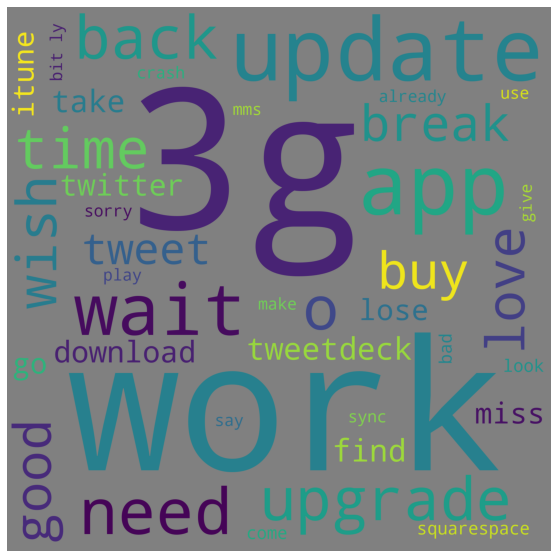

In [17]:
wc = WordCloud(max_words=40, margin=10, background_color='grey',
scale=3, relative_scaling = 0.5, width=600, height=600,
random_state=1).generate(' '.join([word for word in df.cleansed]))
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()
wc.to_file('wordcloud.png') # have a copy of the word cloud saved off as a png

Printing a list of the most frequent words, along with their value count, can also give you a good idea of what your customers are talking about.

In [18]:
# Print a list of word counts
all_words = ' '.join([text for text in df.cleansed])
all_words = all_words.split() 

fdist = nltk.FreqDist(all_words) # creates word frequency distribution
words_df = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())}) # pairs the word with its value count into a new df
words_df.sort_values(by=['count'],ascending=False).head(20) # print the top 20 most frequent words

,word,count
52,3.0,751
65,update,623
26,work,555
85,wait,366
141,app,361
103,3g,345
433,os,323
55,like,307
3435,3gs,277
66,need,253


This is the same list of most frequent words from above, only visualized into a plot!

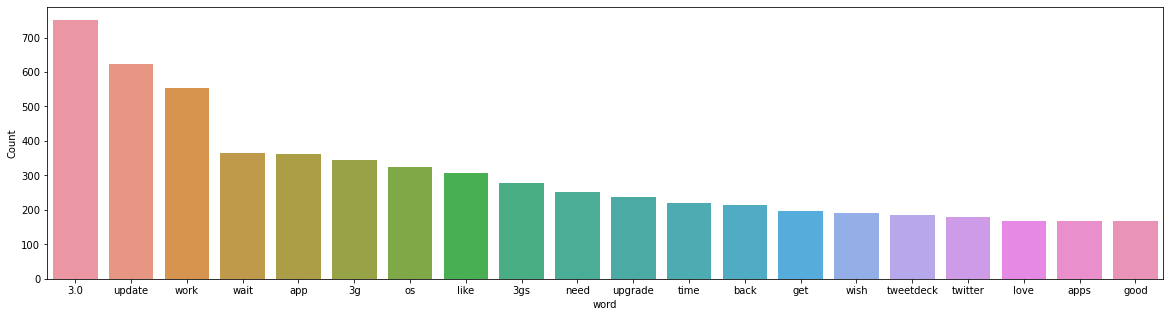

In [19]:
# Visualize the word counts on a plot
d = words_df.nlargest(columns="count", n = 20)      
plt.figure(figsize=(20,5)) 
ax = sns.barplot(data=d, x= "word", y = "count") 
ax.set(ylabel = 'Count') 
plt.show()

# Sentiment Analysis
Sentiment Analysis is a Natural Language Processing technique used to determine the overall "feeling" of a statement - positive, negative, or neutral.

## Translation of Sentiment Analysis Results
Source: https://towardsdatascience.com/almost-real-time-twitter-sentiment-analysis-with-tweep-vader-f88ed5b93b1c

In short, the Positive, Negative and Neutral scores represent the proportion of text that falls in these categories, and the Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1 (most extreme positive).

Example in laymen's terms:

A result of the following numbers means that the sentence is almost half positive (‘pos’: 0.492), more or less neutral (‘neu’: 0.508) and no way negative (‘neg’: 0.0). The most important result is, in fact, the score: ‘compound’, that can state that the text is “Good” (a greater than zero value).

In [20]:
# Initialize the sentiment analysis analyzer
analyzer = SentimentIntensityAnalyzer()

# Give each inquiry scores on their positivity, negativity, neutrality, and a compound (overall) score. Add these scores to the df.
df['sentiment'] = df['cleansed'].apply(lambda x: analyzer.polarity_scores(x))
df = pd.concat([df,df.sentiment.apply(pd.Series)],1)
df.head(20)

,Tweet,tokenized_tweets,stop_filtered_tweets,tokenized_stop_tweets,lemmatized,cleansed,sentiment,neg,neu,pos,compound
0,"feeling lost, naked and confused (jk, sort of).....no iphone for me.","[feeling, lost, ,, naked, and, confused, (, jk, ,, sort, of, ), ....., no, iphone, for, me, .]",feeling lost naked confused jk sort .....,"[feeling, lost, naked, confused, jk, sort, .....]","[feel, lose, naked, confuse, jk, sort, .....]",feel lose naked confuse jk sort .....,"{'neg': 0.438, 'neu': 0.381, 'pos': 0.181, 'compound': -0.4019}",0.438,0.381,0.181,-0.4019
1,"btw my iphone is acting funny, dying quickly and freezing and bs. i'm not admitting anything, just sayin","[btw, my, iphone, is, acting, funny, ,, dying, quickly, and, freezing, and, bs, ., i, 'm, not, admitting, anything, ,, just, sayin]",btw acting funny dying quickly freezing bs admitting anything sayin,"[btw, acting, funny, dying, quickly, freezing, bs, admitting, anything, sayin]","[btw, act, funny, die, quickly, freeze, bs, admit, anything, sayin]",btw act funny die quickly freeze bs admit anything sayin,"{'neg': 0.247, 'neu': 0.38, 'pos': 0.373, 'compound': 0.0}",0.247,0.380,0.373,0.0000
2,nasty budget due and my iphone is being sent to apple today.,"[nasty, budget, due, and, my, iphone, is, being, sent, to, apple, today, .]",nasty budget due sent,"[nasty, budget, due, sent]","[nasty, budget, due, send]",nasty budget due send,"{'neg': 0.545, 'neu': 0.455, 'pos': 0.0, 'compound': -0.5574}",0.545,0.455,0.000,-0.5574
3,synching my contacts from my old mobile to iphone. import does not work well,"[synching, my, contacts, from, my, old, mobile, to, iphone, ., import, does, not, work, well]",synching contacts old mobile import work,"[synching, contacts, old, mobile, import, work]","[synching, contact, old, mobile, import, work]",synching contact old mobile import work,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000
4,"new iphone, yay! not restoring backup, no! stupid apple.","[new, iphone, ,, yay, !, not, restoring, backup, ,, no, !, stupid, apple, .]",yay restoring backup stupid,"[yay, restoring, backup, stupid]","[yay, restore, backup, stupid]",yay restore backup stupid,"{'neg': 0.34, 'neu': 0.1, 'pos': 0.56, 'compound': 0.296}",0.340,0.100,0.560,0.2960
5,caught myself looking up the iphone. promised i wouldn't torcher myself as i still have 6 months left on my current contract,"[caught, myself, looking, up, the, iphone, ., promised, i, would, n't, torcher, myself, as, i, still, have, 6, months, left, on, my, current, contract]",caught looking promised torcher months left current contract,"[caught, looking, promised, torcher, months, left, current, contract]","[catch, look, promise, torcher, months, leave, current, contract]",catch look promise torcher months leave current contract,"{'neg': 0.126, 'neu': 0.632, 'pos': 0.242, 'compound': 0.2732}",0.126,0.632,0.242,0.2732
6,coke zero mobile site broken... on iphone anyway... http://twitpic.com/2y5xp,"[coke, zero, mobile, site, broken, ..., on, iphone, anyway, ..., http, :, //twitpic.com/2y5xp]",coke zero mobile site broken anyway //twitpic.com/2y5xp,"[coke, zero, mobile, site, broken, anyway, //twitpic.com/2y5xp]","[coke, zero, mobile, site, break, anyway, //twitpic.com/2y5xp]",coke zero mobile site break anyway //twitpic.com/2y5xp,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000
7,i will say it out loud - i miss you a-hole and your answers to my iphone questions. now who will help me upgrade to 3.0?,"[i, will, say, it, out, loud, -, i, miss, you, a-hole, and, your, answers, to, my, iphone, questions, ., now, who, will, help, me, upgrade, to, 3.0, ?]",loud miss a-hole answers questions help upgrade 3.0,"[loud, miss, a-hole, answers, questions, help, upgrade, 3.0]","[loud, miss, a-hole, answer, question, help, upgrade, 3.0]",loud miss a-hole answer question help upgrade 3.0,"{'neg': 0.155, 'neu': 0.583, 'pos': 0.262, 'compound': 0.2732}",0.155,0.583,0.262,0.273

The compound score represents the overall sentiment of the statement. Scores range from -1 to 1, where -1 is most negative and 1 is most positive. We will want to categorize each inquiry into being a positive, negative, or neutral statement overall. The inquiry, its scores, and sentiment caregory have been printed into a separate df for easy viewing.

In [21]:
# Create a category to classify each comment as being positive, negative, or neurtal overall
# create a list of our conditions
conditions = [
    (df['compound'] < 0),
    (df['compound'] == 0),
    (df['compound'] > 0)
    ]

# create a list of the values we want to assign for each condition
values = ['Negative', 'Neutral', 'Positive']

# create a new column and use np.select to assign values to it using our lists as arguments
df['sentiment_category'] = np.select(conditions, values)


# Create separate data frame to isolate the cleansed statement with its sentiment
sentimentdf = df[['cleansed','neg','neu','pos','compound','sentiment', 'sentiment_category']]
sentimentdf.head(20)

,cleansed,neg,neu,pos,compound,sentiment,sentiment_category
0,feel lose naked confuse jk sort .....,0.438,0.381,0.181,-0.4019,"{'neg': 0.438, 'neu': 0.381, 'pos': 0.181, 'compound': -0.4019}",Negative
1,btw act funny die quickly freeze bs admit anything sayin,0.247,0.380,0.373,0.0000,"{'neg': 0.247, 'neu': 0.38, 'pos': 0.373, 'compound': 0.0}",Neutral
2,nasty budget due send,0.545,0.455,0.000,-0.5574,"{'neg': 0.545, 'neu': 0.455, 'pos': 0.0, 'compound': -0.5574}",Negative
3,synching contact old mobile import work,0.000,1.000,0.000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral
4,yay restore backup stupid,0.340,0.100,0.560,0.2960,"{'neg': 0.34, 'neu': 0.1, 'pos': 0.56, 'compound': 0.296}",Positive
5,catch look promise torcher months leave current contract,0.126,0.632,0.242,0.2732,"{'neg': 0.126, 'neu': 0.632, 'pos': 0.242, 'compound': 0.2732}",Positive
6,coke zero mobile site break anyway //twitpic.com/2y5xp,0.000,1.000,0.000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral
7,loud miss a-hole answer question help upgrade 3.0,0.155,0.583,0.262,0.2732,"{'neg': 0.155, 'neu': 0.583, 'pos': 0.262, 'compound': 0.2732}",Positive
8,completely addict like bad habit,0.394,0.314,0.291,-0.2466,"{'neg': 0.394, 'neu': 0.314, 'pos': 0.291, 'compound': -0.2466}",Negative
9,fold get tweetie twitteriffic take toooo long update need group reply,0.000,1.000,0.000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral


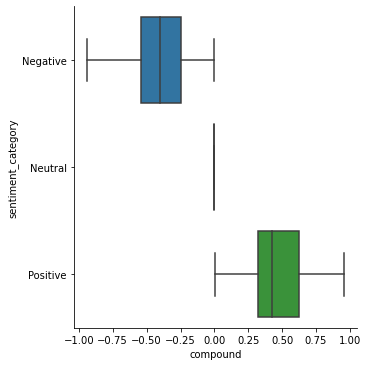

In [22]:
sns.catplot(x="compound", y="sentiment_category", kind="box", data=sentimentdf)

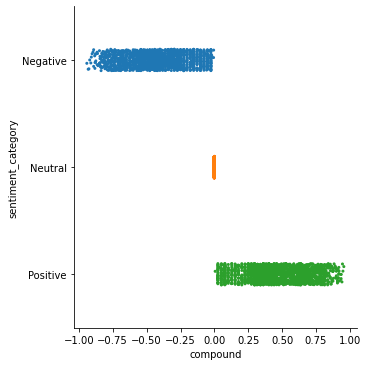

In [23]:
sns.catplot(x="compound", y="sentiment_category", data=sentimentdf, s=3)

In [24]:
sentimentdf.groupby('sentiment_category').count()

,cleansed,neg,neu,pos,compound,sentiment
sentiment_category,,,,,,
Negative,1933,1933,1933,1933,1933,1933
Neutral,2201,2201,2201,2201,2201,2201
Positive,2203,2203,2203,2203,2203,2203


## Sentiment Analysis Spot Checks
In the following df previews, we want to show some output of our classifications to make sure they are rational.

In [25]:
# spot check neutral comments
neutral_check = sentimentdf.loc[sentimentdf['sentiment_category'] == "Neutral"] 
neutral_check.head(10)

,cleansed,neg,neu,pos,compound,sentiment,sentiment_category
1,btw act funny die quickly freeze bs admit anything sayin,0.247,0.38,0.373,0.0,"{'neg': 0.247, 'neu': 0.38, 'pos': 0.373, 'compound': 0.0}",Neutral
3,synching contact old mobile import work,0.000,1.00,0.000,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral
6,coke zero mobile site break anyway //twitpic.com/2y5xp,0.000,1.00,0.000,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral
9,fold get tweetie twitteriffic take toooo long update need group reply,0.000,1.00,0.000,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral
14,interwebs fraked google map something 3bar gprs 3g faster 10mbps cable connection,0.000,1.00,0.000,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral
16,wifi break connect actually another story,0.000,1.00,0.000,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral
18,sooo afford,0.000,1.00,0.000,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral
19,webview control sdk slow load local custom page take marginal time,0.000,1.00,0.000,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral
20,18 months need upgrade come ï¿½500+ contract life need smartphone cheapo talk plan,0.000,1.00,0.000,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral
32,beta tester os3 mms enable moment,0.000,1.00,0.000,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral


In [26]:
# Most positive comments
sentimentdf.sort_values(by=['compound'],ascending=False).head(20) 

,cleansed,neg,neu,pos,compound,sentiment,sentiment_category
2238,best free twitter app tweetie best app period use free wised,0.000,0.255,0.745,0.9552,"{'neg': 0.0, 'neu': 0.255, 'pos': 0.745, 'compound': 0.9552}",Positive
6115,instal app pretty cool stuff soon bike wife awesome weather great relax sunday,0.000,0.325,0.675,0.9485,"{'neg': 0.0, 'neu': 0.325, 'pos': 0.675, 'compound': 0.9485}",Positive
4378,last tweet love win luck best lately squarespace,0.000,0.208,0.792,0.9451,"{'neg': 0.0, 'neu': 0.208, 'pos': 0.792, 'compound': 0.9451}",Positive
4613,wake 7am best solution vote smash love great,0.000,0.213,0.787,0.9413,"{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.9413}",Positive
5935,love free kindle app make super easy read n drift sleep night,0.000,0.329,0.671,0.9360,"{'neg': 0.0, 'neu': 0.329, 'pos': 0.671, 'compound': 0.936}",Positive
6232,love place amazon order loo perfect nice sunny morning,0.000,0.208,0.792,0.9349,"{'neg': 0.0, 'neu': 0.208, 'pos': 0.792, 'compound': 0.9349}",Positive
732,yeiii amzing best gift =d love miss,0.088,0.110,0.802,0.9325,"{'neg': 0.088, 'neu': 0.11, 'pos': 0.802, 'compound': 0.9325}",Positive
5721,favorite movie awesome yes love songs listen lot,0.000,0.222,0.778,0.9325,"{'neg': 0.0, 'neu': 0.222, 'pos': 0.778, 'compound': 0.9325}",Positive
2286,happy hump pretty excite get days woohoo update cuz comp f 'd,0.000,0.345,0.655,0.9231,"{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.9231}",Positive
3875,love g1 sorry win ipod better battery life everything else yr update,0.060,0.324,0.616,0.9186,"{'neg': 0.06, 'neu': 0.324, 'pos': 0.616, 'compound': 0.9186}",Positive


In [27]:
# Most negative comments
sentimentdf.sort_values(by=['compound'],ascending=True).head(20) 

,cleansed,neg,neu,pos,compound,sentiment,sentiment_category
3749,fail fuck dead bad,1.000,0.000,0.000,-0.9413,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9413}",Negative
2801,fuck fuch fuck wait stupid software fail,0.822,0.178,0.000,-0.9313,"{'neg': 0.822, 'neu': 0.178, 'pos': 0.0, 'compound': -0.9313}",Negative
4047,finally hate piss break old fuck piece shit,0.771,0.229,0.000,-0.9260,"{'neg': 0.771, 'neu': 0.229, 'pos': 0.0, 'compound': -0.926}",Negative
5221,fuck fuck fuck fuck go mute handle g1 cost dearly commit suicide,0.619,0.134,0.247,-0.9201,"{'neg': 0.619, 'neu': 0.134, 'pos': 0.247, 'compound': -0.9201}",Negative
5175,facebook app update kill dread death,0.795,0.205,0.000,-0.9118,"{'neg': 0.795, 'neu': 0.205, 'pos': 0.0, 'compound': -0.9118}",Negative
3414,hate hate hate screen wont work answer call get/send texts sorry wonder,0.608,0.392,0.000,-0.9081,"{'neg': 0.608, 'neu': 0.392, 'pos': 0.0, 'compound': -0.9081}",Negative
1557,lack news lack gossip lack everythin steal dude check call log boredom flood mind,0.638,0.362,0.000,-0.9022,"{'neg': 0.638, 'neu': 0.362, 'pos': 0.0, 'compound': -0.9022}",Negative
5307,heh fuck tedious type w/1 finger twitfon tweetdeck lot feature fatally unstable,0.596,0.404,0.000,-0.8957,"{'neg': 0.596, 'neu': 0.404, 'pos': 0.0, 'compound': -0.8957}",Negative
1411,attack evil blue dot sad,0.841,0.159,0.000,-0.8910,"{'neg': 0.841, 'neu': 0.159, 'pos': 0.0, 'compound': -0.891}",Negative
6101,abuse poor throw againsts wall angry,0.779,0.221,0.000,-0.8910,"{'neg': 0.779, 'neu': 0.221, 'pos': 0.0, 'compound': -0.891}",Negative


# Clustering
Now we want to cluster the inquiries into distinct groups based on their subject matter. This is done by vectorizing the inquiries, or in other words, converting each word into a number so it can be processed by the machine. These numbers are then transformed to an array so they can further be analyzed by the computer.

Sources:
 https://sanjayasubedi.com.np/nlp/nlp-with-python-document-clustering/
 
 https://towardsdatascience.com/k-means-clustering-8e1e64c1561c

In [28]:
# vectorize the text
data = df['cleansed']
vec = TfidfVectorizer(stop_words='english',max_features = 1000)
tf_idf = vec.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [29]:
# Preview feature names
pd.DataFrame(tf_idf_array,columns=vec.get_feature_names()).head

<bound method NDFrame.head of        00   02   09   10  100  10am   11   12   14   15  ...  year  years  \
0     0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0   0.0     
1     0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0   0.0     
2     0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0   0.0     
3     0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0   0.0     
4     0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0   0.0     
...   ...  ...  ...  ...  ...  ...   ...  ...  ...  ...  ...  ...   ...     
6332  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0   0.0     
6333  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0   0.0     
6334  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0   0.0     
6335  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0   0.0     
6336  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0   0.0     

      yep  yes  yfrog  youtube   yr  yrs  yup

The following class uses Kmeans clustering to conduct unsupervised machine learning on our data. First, we determine the number of clusters. Next, we determine the centers of the centroids, which are the ellipses-shaped figures that represent each cluster. A data point is then assigned to a cluster, which is determined by whichever centroid it is closest to. These clusters and their centers are continutally updated as more data is added to the model.

In [30]:
class Kmeans:
    """ K Means Clustering
    
    Parameters
    -----------
        k: int , number of clusters
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithm, default: 200
        
    Attributes
    -----------
       centroids: array, k, number_features
       
       cluster_labels: label for each data point
       
    """
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
            
    
    def initialise_centroids(self, data):
        """Randomly Initialise Centroids
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        centroids: array of k centroids chosen as random data points 
        """
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]

        return self.centroids
    
    
    def assign_clusters(self, data):
        """Compute distance of data from clusters and assign data point
           to closest cluster.
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
            
        """
        
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return  self.cluster_labels
    
    
    def update_centroids(self, data):
        """Computes average of all data points in cluster and
           assigns new centroids as average of data points
        
        Parameters
        -----------
        data: array or matrix, number_rows, number_features
        
        Returns
        -----------
        centroids: array, k, number_features
        """
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        
        return self.centroids
    
    
    
    def predict(self, data):
        """Predict which cluster data point belongs to
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
        """
        
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        """
        This function contains the main loop to fit the algorithm
        Implements initialise centroids and update_centroids
        according to max_iter
        -----------------------
        
        Returns
        -------
        instance of kmeans class
            
        """
        self.centroids = self.initialise_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):

            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
            if iter % 100 == 0:
                print("Running Model Iteration %d " %iter)
        print("Model finished running")
        return self 

## Choosing an optimal number of clusters
In order to determine what number of clusters is optimal, we use what is called the elbow method. On this plot, the optimal number of clusters is shown where the line starts to bow out like an elbow and then flatten - here, it is at 3 clusters.

You may need to play around a bit with the range in the number_clusters variable to arrive at your solution. If we have too few clusters, the resulting clusters will be too broad and generic and not really extract a whole lot of valuable insights from the data. If we have too many clusters, each cluster becomes to granular and you are at risk for over-fitting.

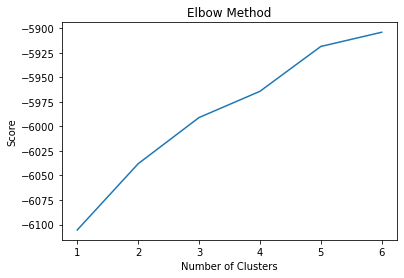

In [31]:
# Determining optimal numbers of clusters using the elbow method on a plot
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(tf_idf_array).score(tf_idf_array) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


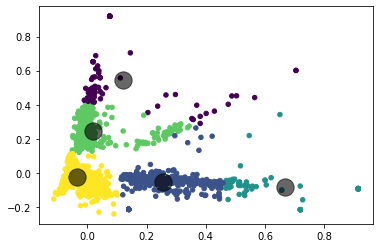

In [54]:
# Plot with 5 clusters. Each cluster is represented by its own color.
sklearn_pca = PCA(n_components = 2) # plots the data on a 2D space
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = Kmeans(5, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)
df['predicted_values'] = test_e.predict(Y_sklearn) # add these values to the original df

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=20, cmap='viridis')

# Centers are shown in the plot as the larger black circles.
centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

In [55]:
# Silhouette score is a good model verification metric for UNLABELLED data.
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. 
# Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
# https://sanjayasubedi.com.np/nlp/nlp-with-python-document-clustering/
# As evident in the graph above and with this metric being close to 0, it is evident some overlapping is present.

silhouette_score(tf_idf, predicted_values)

0.0028083633099271156

Here, we print the predicted cluster vaules to the new df. Review a few classifications and see if they make sense with the text statement that they were assigned to.

In [34]:
# Print predicted values in the sentimentdf and change name to clusterdf
clusterdf = df[['cleansed','neg','neu','pos','compound','sentiment', 'sentiment_category','predicted_values']]
clusterdf.head(50)

,cleansed,neg,neu,pos,compound,sentiment,sentiment_category,predicted_values
0,feel lose naked confuse jk sort .....,0.438,0.381,0.181,-0.4019,"{'neg': 0.438, 'neu': 0.381, 'pos': 0.181, 'compound': -0.4019}",Negative,4
1,btw act funny die quickly freeze bs admit anything sayin,0.247,0.380,0.373,0.0000,"{'neg': 0.247, 'neu': 0.38, 'pos': 0.373, 'compound': 0.0}",Neutral,4
2,nasty budget due send,0.545,0.455,0.000,-0.5574,"{'neg': 0.545, 'neu': 0.455, 'pos': 0.0, 'compound': -0.5574}",Negative,4
3,synching contact old mobile import work,0.000,1.000,0.000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral,0
4,yay restore backup stupid,0.340,0.100,0.560,0.2960,"{'neg': 0.34, 'neu': 0.1, 'pos': 0.56, 'compound': 0.296}",Positive,4
5,catch look promise torcher months leave current contract,0.126,0.632,0.242,0.2732,"{'neg': 0.126, 'neu': 0.632, 'pos': 0.242, 'compound': 0.2732}",Positive,4
6,coke zero mobile site break anyway //twitpic.com/2y5xp,0.000,1.000,0.000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral,4
7,loud miss a-hole answer question help upgrade 3.0,0.155,0.583,0.262,0.2732,"{'neg': 0.155, 'neu': 0.583, 'pos': 0.262, 'compound': 0.2732}",Positive,4
8,completely addict like bad habit,0.394,0.314,0.291,-0.2466,"{'neg': 0.394, 'neu': 0.314, 'pos': 0.291, 'compound': -0.2466}",Negative,4
9,fold get tweetie twitteriffic take toooo long update need group reply,0.000,1.000,0.000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Neutral,2


In [35]:
# Show how many inquiries fall in each cluster
clusterdf.groupby('predicted_values').count()

,cleansed,neg,neu,pos,compound,sentiment,sentiment_category
predicted_values,,,,,,,
0,504,504,504,504,504,504,504
1,320,320,320,320,320,320,320
2,491,491,491,491,491,491,491
3,682,682,682,682,682,682,682
4,4340,4340,4340,4340,4340,4340,4340


## Print the top words in each cluster
Printing the top words in each cluster will help us discover the theme or topic of each. These topics were determined using industry knowledge. Be mindful that topics and number of clusters may change if more data is added to the model. We will create a new column to assign these labels.

For this analysis, the resulting clusters are as follows:

In [36]:
# Cluster 0
# create new df with only inquiries that belong to this cluster
cluster0_words = clusterdf.loc[clusterdf['predicted_values'] == 0] 
cluster0_words.head()

# Print a list of word counts in this cluster
all_words = ' '.join([text for text in cluster0_words.cleansed])
all_words = all_words.split() 

fdist = nltk.FreqDist(all_words) # creates word frequency distribution
words_df = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())}) # pairs the word with its value count into a new df
words_df.sort_values(by=['count'],ascending=False).head(20) # print the top 10 most frequent words

,word,count
5,work,527
34,3.0,71
189,update,64
7,app,42
42,twitter,28
167,wait,27
569,os,24
142,apps,22
135,software,22
30,like,21


In [37]:
# Cluster 1
# create new df with only inquiries that belong to this cluster
cluster1_words = clusterdf.loc[clusterdf['predicted_values'] == 1] 
cluster1_words.head()

# Print a list of word counts in this cluster
all_words = ' '.join([text for text in cluster1_words.cleansed])
all_words = all_words.split() 

fdist = nltk.FreqDist(all_words) # creates word frequency distribution
words_df = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())}) # pairs the word with its value count into a new df
words_df.sort_values(by=['count'],ascending=False).head(20) # print the top 10 most frequent words

,word,count
7,3g,333
85,upgrade,36
200,3gs,36
204,wait,29
272,3.0,27
12,buy,21
301,sell,20
344,work,19
54,get,18
14,like,18


In [38]:
# Cluster 2
# create new df with only inquiries that belong to this cluster
cluster2_words = clusterdf.loc[clusterdf['predicted_values'] == 2] 
cluster2_words.head()

# Print a list of word counts in this cluster
all_words = ' '.join([text for text in cluster2_words.cleansed])
all_words = all_words.split() 

fdist = nltk.FreqDist(all_words) # creates word frequency distribution
words_df = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())}) # pairs the word with its value count into a new df
words_df.sort_values(by=['count'],ascending=False).head(20) # print the top 10 most frequent words

,word,count
7,update,529
103,3.0,167
89,os,59
218,wait,53
104,software,45
146,itunes,38
251,time,34
8,need,25
132,like,25
4,take,23


In [39]:
# Cluster 3
# create new df with only inquiries that belong to this cluster
cluster3_words = clusterdf.loc[clusterdf['predicted_values'] == 3] 
cluster3_words.head()

# Print a list of word counts in this cluster
all_words = ' '.join([text for text in cluster3_words.cleansed])
all_words = all_words.split() 

fdist = nltk.FreqDist(all_words) # creates word frequency distribution
words_df = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())}) # pairs the word with its value count into a new df
words_df.sort_values(by=['count'],ascending=False).head(20) # print the top 10 most frequent words

,word,count
10,app,290
723,tweetdeck,164
4,twitter,128
17,crash,118
100,os,93
101,3.0,87
36,like,52
8,apps,51
359,download,50
112,tweet,45


In [40]:
# Cluster 4
# create new df with only inquiries that belong to this cluster
cluster4_words = clusterdf.loc[clusterdf['predicted_values'] == 4] 
cluster4_words.head()

# Print a list of word counts in this cluster
all_words = ' '.join([text for text in cluster4_words.cleansed])
all_words = all_words.split() 

fdist = nltk.FreqDist(all_words) # creates word frequency distribution
words_df = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())}) # pairs the word with its value count into a new df
words_df.sort_values(by=['count'],ascending=False).head(20) # print the top 10 most frequent words

,word,count
47,3.0,399
70,wait,254
2867,3gs,221
50,like,191
46,upgrade,169
60,wish,162
57,need,157
133,back,150
2823,squarespace,140
352,os,139


In [41]:
# Create a category to classify each inquiry based on its cluster.
# create a list of our conditions
conditions = [
    (df['predicted_values'] == 0),
    (df['predicted_values'] == 1),
    (df['predicted_values'] == 2),
    (df['predicted_values'] == 3),
    (df['predicted_values'] == 4)
    ]

# create a list of the values we want to assign for each condition
values = ['Upgrades','3G', 'Software and Application Updates', 'Twitter', 'Product Inquiries and Feedback']

# create a new column and use np.select to assign values to it using our lists as arguments
df['inquiry_category'] = np.select(conditions, values)
df.head(50)

,Tweet,tokenized_tweets,stop_filtered_tweets,tokenized_stop_tweets,lemmatized,cleansed,sentiment,neg,neu,pos,compound,sentiment_category,predicted_values,inquiry_category
0,"feeling lost, naked and confused (jk, sort of).....no iphone for me.","[feeling, lost, ,, naked, and, confused, (, jk, ,, sort, of, ), ....., no, iphone, for, me, .]",feeling lost naked confused jk sort .....,"[feeling, lost, naked, confused, jk, sort, .....]","[feel, lose, naked, confuse, jk, sort, .....]",feel lose naked confuse jk sort .....,"{'neg': 0.438, 'neu': 0.381, 'pos': 0.181, 'compound': -0.4019}",0.438,0.381,0.181,-0.4019,Negative,4,Product Inquiries and Feedback
1,"btw my iphone is acting funny, dying quickly and freezing and bs. i'm not admitting anything, just sayin","[btw, my, iphone, is, acting, funny, ,, dying, quickly, and, freezing, and, bs, ., i, 'm, not, admitting, anything, ,, just, sayin]",btw acting funny dying quickly freezing bs admitting anything sayin,"[btw, acting, funny, dying, quickly, freezing, bs, admitting, anything, sayin]","[btw, act, funny, die, quickly, freeze, bs, admit, anything, sayin]",btw act funny die quickly freeze bs admit anything sayin,"{'neg': 0.247, 'neu': 0.38, 'pos': 0.373, 'compound': 0.0}",0.247,0.380,0.373,0.0000,Neutral,4,Product Inquiries and Feedback
2,nasty budget due and my iphone is being sent to apple today.,"[nasty, budget, due, and, my, iphone, is, being, sent, to, apple, today, .]",nasty budget due sent,"[nasty, budget, due, sent]","[nasty, budget, due, send]",nasty budget due send,"{'neg': 0.545, 'neu': 0.455, 'pos': 0.0, 'compound': -0.5574}",0.545,0.455,0.000,-0.5574,Negative,4,Product Inquiries and Feedback
3,synching my contacts from my old mobile to iphone. import does not work well,"[synching, my, contacts, from, my, old, mobile, to, iphone, ., import, does, not, work, well]",synching contacts old mobile import work,"[synching, contacts, old, mobile, import, work]","[synching, contact, old, mobile, import, work]",synching contact old mobile import work,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,Neutral,0,Upgrades
4,"new iphone, yay! not restoring backup, no! stupid apple.","[new, iphone, ,, yay, !, not, restoring, backup, ,, no, !, stupid, apple, .]",yay restoring backup stupid,"[yay, restoring, backup, stupid]","[yay, restore, backup, stupid]",yay restore backup stupid,"{'neg': 0.34, 'neu': 0.1, 'pos': 0.56, 'compound': 0.296}",0.340,0.100,0.560,0.2960,Positive,4,Product Inquiries and Feedback
5,caught myself looking up the iphone. promised i wouldn't torcher myself as i still have 6 months left on my current contract,"[caught, myself, looking, up, the, iphone, ., promised, i, would, n't, torcher, myself, as, i, still, have, 6, months, left, on, my, current, contract]",caught looking promised torcher months left current contract,"[caught, looking, promised, torcher, months, left, current, contract]","[catch, look, promise, torcher, months, leave, current, contract]",catch look promise torcher months leave current contract,"{'neg': 0.126, 'neu': 0.632, 'pos': 0.242, 'compound': 0.2732}",0.126,0.632,0.242,0.2732,Positive,4,Product Inquiries and Feedback
6,coke zero mobile site broken... on iphone anyway... http://twitpic.com/2y5xp,"[coke, zero, mobile, site, broken, ..., on, iphone, anyway, ..., http, :, //twitpic.com/2y5xp]",coke zero mobile site broken anyway //twitpic.com/2y5xp,"[coke, zero, mobile, site, broken, anyway, //twitpic.com/2y5xp]","[coke, zero, mobile, site, break, anyway, //twitpic.com/2y5xp]",coke zero mobile site break anyway //twitpic.com/2y5xp,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,Neutral,4,Product Inquiries and Feedback
7,i will say it out loud - i miss you a-hole and your answers to my iphone questions. now who will help me upgrade to 3.0?,"[i, will, say, it, out, loud, -, i, miss, you, a-hole, and, your, answers, to, my, iphone, questions, ., now, who, will, help, me, upgrade, to, 3

In [42]:
# Show how many of each type of complaint we have recieved. 
df.groupby('inquiry_category').count()

,Tweet,tokenized_tweets,stop_filtered_tweets,tokenized_stop_tweets,lemmatized,cleansed,sentiment,neg,neu,pos,compound,sentiment_category,predicted_values
inquiry_category,,,,,,,,,,,,,
3G,320,320,320,320,320,320,320,320,320,320,320,320,320
Product Inquiries and Feedback,4340,4340,4340,4340,4340,4340,4340,4340,4340,4340,4340,4340,4340
Software and Application Updates,491,491,491,491,491,491,491,491,491,491,491,491,491
Twitter,682,682,682,682,682,682,682,682,682,682,682,682,682
Upgrades,504,504,504,504,504,504,504,504,504,504,504,504,504


In [43]:
# spot check cluster 0
cluster0 = df.loc[df['predicted_values'] == 0] 
cluster0.head(5)

,Tweet,tokenized_tweets,stop_filtered_tweets,tokenized_stop_tweets,lemmatized,cleansed,sentiment,neg,neu,pos,compound,sentiment_category,predicted_values,inquiry_category
3,synching my contacts from my old mobile to iphone. import does not work well,"[synching, my, contacts, from, my, old, mobile, to, iphone, ., import, does, not, work, well]",synching contacts old mobile import work,"[synching, contacts, old, mobile, import, work]","[synching, contact, old, mobile, import, work]",synching contact old mobile import work,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,Neutral,0,Upgrades
22,"thanks but aka-aki app for iphone seems to be blocked by french operator bouygues telecom, it only works in wifi","[thanks, but, aka-aki, app, for, iphone, seems, to, be, blocked, by, french, operator, bouygues, telecom, ,, it, only, works, in, wifi]",aka-aki app seems blocked french operator bouygues telecom works wifi,"[aka-aki, app, seems, blocked, french, operator, bouygues, telecom, works, wifi]","[aka-aki, app, seem, block, french, operator, bouygues, telecom, work, wifi]",aka-aki app seem block french operator bouygues telecom work wifi,"{'neg': 0.244, 'neu': 0.756, 'pos': 0.0, 'compound': -0.4404}",0.244,0.756,0.000,-0.4404,Negative,0,Upgrades
33,i *know* coveritlive mobile works on an iphone. but apparently i don't have one of those #txdla09,"[i, *, know, *, coveritlive, mobile, works, on, an, iphone, ., but, apparently, i, do, n't, have, one, of, those, #, txdla09]",coveritlive mobile works apparently txdla09,"[coveritlive, mobile, works, apparently, txdla09]","[coveritlive, mobile, work, apparently, txdla09]",coveritlive mobile work apparently txdla09,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,Neutral,0,Upgrades
50,iphone's not working...i feel so alone,"[iphone, 's, not, working, ..., i, feel, so, alone]",working feel alone,"[working, feel, alone]","[work, feel, alone]",work feel alone,"{'neg': 0.5, 'neu': 0.5, 'pos': 0.0, 'compound': -0.25}",0.500,0.500,0.000,-0.2500,Negative,0,Upgrades
60,"yeah!!!! because when ever i try to use my iphone on wireless, no work #geekmeet","[yeah, !, !, !, !, because, when, ever, i, try, to, use, my, iphone, on, wireless, ,, no, work, #, geekmeet]",yeah ever wireless work geekmeet,"[yeah, ever, wireless, work, geekmeet]","[yeah, ever, wireless, work, geekmeet]",yeah ever wireless work geekmeet,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'compound': 0.296}",0.000,0.645,0.355,0.2960,Positive,0,Upgrades


In [44]:
# spot check cluster 1
cluster1 = df.loc[df['predicted_values'] == 1] 
cluster1.head(5)

,Tweet,tokenized_tweets,stop_filtered_tweets,tokenized_stop_tweets,lemmatized,cleansed,sentiment,neg,neu,pos,compound,sentiment_category,predicted_values,inquiry_category
14,my interwebs is so fraked up that i can google maps something on my iphone (3bar gprs ..no 3g!) faster than my 10mbps cable connection!,"[my, interwebs, is, so, fraked, up, that, i, can, google, maps, something, on, my, iphone, (, 3bar, gprs, .., no, 3g, !, ), faster, than, my, 10mbps, cable, connection, !]",interwebs fraked google maps something 3bar gprs 3g faster 10mbps cable connection,"[interwebs, fraked, google, maps, something, 3bar, gprs, 3g, faster, 10mbps, cable, connection]","[interwebs, fraked, google, map, something, 3bar, gprs, 3g, faster, 10mbps, cable, connection]",interwebs fraked google map something 3bar gprs 3g faster 10mbps cable connection,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,Neutral,1,3G
21,"i bought an iphone 3g off ebay like 2weeks ago, still hasn't come","[i, bought, an, iphone, 3g, off, ebay, like, 2weeks, ago, ,, still, has, n't, come]",bought 3g ebay like 2weeks ago,"[bought, 3g, ebay, like, 2weeks, ago]","[buy, 3g, ebay, like, 2weeks, ago]",buy 3g ebay like 2weeks ago,"{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.3612}",0.000,0.667,0.333,0.3612,Positive,1,3G
75,the only place gothere.sg can't find is where my lost iphone 3g is,"[the, only, place, gothere.sg, ca, n't, find, is, where, my, lost, iphone, 3g, is]",place gothere.sg find lost 3g,"[place, gothere.sg, find, lost, 3g]","[place, gothere.sg, find, lose, 3g]",place gothere.sg find lose 3g,"{'neg': 0.403, 'neu': 0.597, 'pos': 0.0, 'compound': -0.4019}",0.403,0.597,0.000,-0.4019,Negative,1,3G
106,need a 3g iphone to fully enjoy trapster,"[need, a, 3g, iphone, to, fully, enjoy, trapster]",need 3g fully enjoy trapster,"[need, 3g, fully, enjoy, trapster]","[need, 3g, fully, enjoy, trapster]",need 3g fully enjoy trapster,"{'neg': 0.0, 'neu': 0.534, 'pos': 0.466, 'compound': 0.5413}",0.000,0.534,0.466,0.5413,Positive,1,3G
134,"i got my iphone 3g, and i'm still not sure whether to keep it or get a blackberry instead","[i, got, my, iphone, 3g, ,, and, i, 'm, still, not, sure, whether, to, keep, it, or, get, a, blackberry, instead]",3g sure whether blackberry instead,"[3g, sure, whether, blackberry, instead]","[3g, sure, whether, blackberry, instead]",3g sure whether blackberry instead,"{'neg': 0.0, 'neu': 0.635, 'pos': 0.365, 'compound': 0.3182}",0.000,0.635,0.365,0.3182,Positive,1,3G


In [45]:
# spot check cluster 2
cluster2 = df.loc[df['predicted_values'] == 2] 
cluster2.head(5)

,Tweet,tokenized_tweets,stop_filtered_tweets,tokenized_stop_tweets,lemmatized,cleansed,sentiment,neg,neu,pos,compound,sentiment_category,predicted_values,inquiry_category
9,"thats it!, im folding and getting tweetie for my iphone - #twitteriffic is taking toooo long to update!. i need grouping &amp; replies.","[thats, it, !, ,, im, folding, and, getting, tweetie, for, my, iphone, -, #, twitteriffic, is, taking, toooo, long, to, update, !, ., i, need, grouping, &, amp, ;, replies, .]",folding getting tweetie twitteriffic taking toooo long update need grouping replies,"[folding, getting, tweetie, twitteriffic, taking, toooo, long, update, need, grouping, replies]","[fold, get, tweetie, twitteriffic, take, toooo, long, update, need, group, reply]",fold get tweetie twitteriffic take toooo long update need group reply,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,Neutral,2,Software and Application Updates
93,#ilhm soul children of chgo sing &quot;america the beautiful&quot; iphone battery won't last 2 more hours of updates.,"[#, ilhm, soul, children, of, chgo, sing, &, quot, ;, america, the, beautiful, &, quot, ;, iphone, battery, wo, n't, last, 2, more, hours, of, updates, .]",ilhm soul children chgo sing america beautiful battery last hours updates,"[ilhm, soul, children, chgo, sing, america, beautiful, battery, last, hours, updates]","[ilhm, soul, children, chgo, sing, america, beautiful, battery, last, hours, update]",ilhm soul children chgo sing america beautiful battery last hours update,"{'neg': 0.0, 'neu': 0.719, 'pos': 0.281, 'compound': 0.5994}",0.000,0.719,0.281,0.5994,Positive,2,Software and Application Updates
155,the new update for #geodefence won't install on my beta 4 #iphone buh!,"[the, new, update, for, #, geodefence, wo, n't, install, on, my, beta, 4, #, iphone, buh, !]",update geodefence install beta buh,"[update, geodefence, install, beta, buh]","[update, geodefence, install, beta, buh]",update geodefence install beta buh,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,Neutral,2,Software and Application Updates
160,"follow up on the tiger woods iphone game....it sometimes crashes, idk why...hopefully they give it an update or i will be","[follow, up, on, the, tiger, woods, iphone, game, ...., it, sometimes, crashes, ,, idk, why, ..., hopefully, they, give, it, an, update, or, i, will, be]",follow tiger woods game sometimes crashes idk hopefully give update,"[follow, tiger, woods, game, sometimes, crashes, idk, hopefully, give, update]","[follow, tiger, woods, game, sometimes, crash, idk, hopefully, give, update]",follow tiger woods game sometimes crash idk hopefully give update,"{'neg': 0.297, 'neu': 0.507, 'pos': 0.196, 'compound': -0.1027}",0.297,0.507,0.196,-0.1027,Negative,2,Software and Application Updates
162,"when u update from text, u can only send updates, they're not sent to your fone i want an iphone..","[when, u, update, from, text, ,, u, can, only, send, updates, ,, they, 're, not, sent, to, your, fone, i, want, an, iphone, ..]",update text send updates 're sent fone,"[update, text, send, updates, 're, sent, fone]","[update, text, send, update, 're, send, fone]",update text send update're send fone,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,Neutral,2,Software and Application Updates


In [46]:
# spot check cluster 3
cluster3 = df.loc[df['predicted_values'] == 3] 
cluster3.head(5)

,Tweet,tokenized_tweets,stop_filtered_tweets,tokenized_stop_tweets,lemmatized,cleansed,sentiment,neg,neu,pos,compound,sentiment_category,predicted_values,inquiry_category
34,"has no internet access and needs an iphone, clearly, to keep up with twitter. life without twitter is not the same","[has, no, internet, access, and, needs, an, iphone, ,, clearly, ,, to, keep, up, with, twitter, ., life, without, twitter, is, not, the, same]",internet access needs clearly twitter life without twitter,"[internet, access, needs, clearly, twitter, life, without, twitter]","[internet, access, need, clearly, twitter, life, without, twitter]",internet access need clearly twitter life without twitter,"{'neg': 0.0, 'neu': 0.722, 'pos': 0.278, 'compound': 0.4019}",0.000,0.722,0.278,0.4019,Positive,3,Twitter
35,"i see all of those really cool apps for the iphone on the commercials, but she. i look in the app store there all dumb games","[i, see, all, of, those, really, cool, apps, for, the, iphone, on, the, commercials, ,, but, she, ., i, look, in, the, app, store, there, all, dumb, games]",cool apps commercials app store dumb games,"[cool, apps, commercials, app, store, dumb, games]","[cool, apps, commercials, app, store, dumb, game]",cool apps commercials app store dumb game,"{'neg': 0.311, 'neu': 0.472, 'pos': 0.217, 'compound': -0.25}",0.311,0.472,0.217,-0.2500,Negative,3,Twitter
43,my iphone has gone so slow and keeps crashing,"[my, iphone, has, gone, so, slow, and, keeps, crashing]",gone slow keeps crashing,"[gone, slow, keeps, crashing]","[go, slow, keep, crash]",go slow keep crash,"{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'compound': -0.4019}",0.474,0.526,0.000,-0.4019,Negative,3,Twitter
44,thanks! gravity s60 twitter client seems to be far better. sadly it costs 8 euros while similar things for iphone are free,"[thanks, !, gravity, s60, twitter, client, seems, to, be, far, better, ., sadly, it, costs, 8, euros, while, similar, things, for, iphone, are, free]",gravity s60 twitter client seems far better sadly costs euros similar things free,"[gravity, s60, twitter, client, seems, far, better, sadly, costs, euros, similar, things, free]","[gravity, s60, twitter, client, seem, far, better, sadly, cost, euros, similar, things, free]",gravity s60 twitter client seem far better sadly cost euros similar things free,"{'neg': 0.147, 'neu': 0.526, 'pos': 0.326, 'compound': 0.5267}",0.147,0.526,0.326,0.5267,Positive,3,Twitter
51,can't find you on ustream iphone app,"[ca, n't, find, you, on, ustream, iphone, app]",find ustream app,"[find, ustream, app]","[find, ustream, app]",find ustream app,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,Neutral,3,Twitter


In [47]:
# spot check cluster 4
cluster4 = df.loc[df['predicted_values'] == 4] 
cluster4.head(5)

,Tweet,tokenized_tweets,stop_filtered_tweets,tokenized_stop_tweets,lemmatized,cleansed,sentiment,neg,neu,pos,compound,sentiment_category,predicted_values,inquiry_category
0,"feeling lost, naked and confused (jk, sort of).....no iphone for me.","[feeling, lost, ,, naked, and, confused, (, jk, ,, sort, of, ), ....., no, iphone, for, me, .]",feeling lost naked confused jk sort .....,"[feeling, lost, naked, confused, jk, sort, .....]","[feel, lose, naked, confuse, jk, sort, .....]",feel lose naked confuse jk sort .....,"{'neg': 0.438, 'neu': 0.381, 'pos': 0.181, 'compound': -0.4019}",0.438,0.381,0.181,-0.4019,Negative,4,Product Inquiries and Feedback
1,"btw my iphone is acting funny, dying quickly and freezing and bs. i'm not admitting anything, just sayin","[btw, my, iphone, is, acting, funny, ,, dying, quickly, and, freezing, and, bs, ., i, 'm, not, admitting, anything, ,, just, sayin]",btw acting funny dying quickly freezing bs admitting anything sayin,"[btw, acting, funny, dying, quickly, freezing, bs, admitting, anything, sayin]","[btw, act, funny, die, quickly, freeze, bs, admit, anything, sayin]",btw act funny die quickly freeze bs admit anything sayin,"{'neg': 0.247, 'neu': 0.38, 'pos': 0.373, 'compound': 0.0}",0.247,0.380,0.373,0.0000,Neutral,4,Product Inquiries and Feedback
2,nasty budget due and my iphone is being sent to apple today.,"[nasty, budget, due, and, my, iphone, is, being, sent, to, apple, today, .]",nasty budget due sent,"[nasty, budget, due, sent]","[nasty, budget, due, send]",nasty budget due send,"{'neg': 0.545, 'neu': 0.455, 'pos': 0.0, 'compound': -0.5574}",0.545,0.455,0.000,-0.5574,Negative,4,Product Inquiries and Feedback
4,"new iphone, yay! not restoring backup, no! stupid apple.","[new, iphone, ,, yay, !, not, restoring, backup, ,, no, !, stupid, apple, .]",yay restoring backup stupid,"[yay, restoring, backup, stupid]","[yay, restore, backup, stupid]",yay restore backup stupid,"{'neg': 0.34, 'neu': 0.1, 'pos': 0.56, 'compound': 0.296}",0.340,0.100,0.560,0.2960,Positive,4,Product Inquiries and Feedback
5,caught myself looking up the iphone. promised i wouldn't torcher myself as i still have 6 months left on my current contract,"[caught, myself, looking, up, the, iphone, ., promised, i, would, n't, torcher, myself, as, i, still, have, 6, months, left, on, my, current, contract]",caught looking promised torcher months left current contract,"[caught, looking, promised, torcher, months, left, current, contract]","[catch, look, promise, torcher, months, leave, current, contract]",catch look promise torcher months leave current contract,"{'neg': 0.126, 'neu': 0.632, 'pos': 0.242, 'compound': 0.2732}",0.126,0.632,0.242,0.2732,Positive,4,Product Inquiries and Feedback
